In [1]:
!pip install --upgrade openpyxl==3.1.0 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from time import time

In [4]:
df = pd.read_excel("1 - Project Data.xlsx")

## Initial Analysis

In [5]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,Competitor had better devices


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [7]:
text_cols = df.select_dtypes(include="object").columns
print("Number of unique values in text features:\n")
for c in text_cols:
    print(f"{c}\t: {df[c].nunique()}")
    if df[c].nunique() < 5:
        print(df[c].value_counts())
    print()

Number of unique values in text features:

CustomerID	: 7043

Country	: 1
Country
United States    7043
Name: count, dtype: int64

State	: 1
State
California    7043
Name: count, dtype: int64

City	: 1129

Lat Long	: 1652

Gender	: 2
Gender
Male      3555
Female    3488
Name: count, dtype: int64

Senior Citizen	: 2
Senior Citizen
No     5901
Yes    1142
Name: count, dtype: int64

Partner	: 2
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Dependents	: 2
Dependents
No     5416
Yes    1627
Name: count, dtype: int64

Phone Service	: 2
Phone Service
Yes    6361
No      682
Name: count, dtype: int64

Multiple Lines	: 3
Multiple Lines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

Internet Service	: 3
Internet Service
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

Online Security	: 3
Online Security
No                     3498
Yes                    2019
No internet service    1526
Name:

In [8]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000


In [9]:
num_cols = df.select_dtypes(exclude="object").columns
print("Number of unique values in numeric features:\n")
for n in num_cols:
    print(f"{n}\t: {df[n].nunique()}")

Number of unique values in numeric features:

Count	: 1
Zip Code	: 1652
Latitude	: 1652
Longitude	: 1651
Tenure Months	: 73
Monthly Charges	: 1585
Churn Value	: 2


In [10]:
# check if any churn label is yes but churn value does not equal to 1
print(df[(df['Churn Label'] == 'Yes') & (df['Churn Value'] != 1)].count())

CustomerID           0
Count                0
Country              0
State                0
City                 0
Zip Code             0
Lat Long             0
Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Label          0
Churn Value          0
Churn Reason         0
dtype: int64


In [11]:
# check if any churn label is no but churn value does not equal to 0
print(df[(df['Churn Label'] == 'No') & (df['Churn Value'] != 0)].count())

CustomerID           0
Count                0
Country              0
State                0
City                 0
Zip Code             0
Lat Long             0
Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Label          0
Churn Value          0
Churn Reason         0
dtype: int64


### Findings
* Features with only 1 unique value across all features: `Country`, `State`, `Count`.
* Features with all records unique: `CustomerID`.
* Categorical features: `Gender`,
`Senior Citizen`,
`Partner`,
`Dependents`,
`Phone Service`,
`Multiple Lines`,
`Internet Service`,
`Online Security`,
`Online Backup`,
`Device Protection`,
`Tech Support`,
`Streaming TV`,
`Streaming Movies`,
`Contract`,
`Paperless Billing`,
`Payment Method`.
* Duplicate values: `Lat Long` also found in `Latitude`, `Longitude`. Also, `Zip Code` shares same number of unique values with `Lat Long` `Latitude`. 
* Missing values: `Churn Reason`. Could that be limited to only customers who churned?
* Duplicate targets: `Churn Value` = 0 when `Churn Label` = "No", `Churn Value` = 1 when `Churn Label` = "Yes". 

### Next Action:
* Drop `Country`, `State`, `Count`, `Churn Label`.
* Drop `Lat Long`, `Latitude`, `Longitude` and preserve area information using `Zip Code` only.
* Convert `CustomerID` from feature to index to preserve the record uniqueness but exclude them from modelling.
* Convert all categorical features to numeric values.

## Train Test Split
80/20 split

In [12]:
df = df.set_index('CustomerID')
df.head(2)

,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Reason
CustomerID,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,Competitor made better offer
9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,Moved


In [13]:
target = 'Churn Value'
y = df[target].copy()
X = df.copy()
X = X.drop([target], axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=1204)

In [15]:
assert(all(X_train.index==y_train.index)), "Index mismatch in training set"
assert(all(X_test.index==y_test.index)), "Index mismatch in test set"

## Data Transformation

In [16]:
## Apply the same mapping to columns that have the same 2 value structure:
def map_binary(col):
    return col.map({'Yes':1, 'No':0, 1:1, 0:0})

##Apply the same mapping to columns that have the same 3 value structure:
def map_internet(col):
    return col.map({'Yes': 1, 'No': 0, 'No internet service': 0, 1:1, 0:0})

In [17]:
def mapper(data, drop_total_charges=False):
    data = data.copy()
    
    binary_mapping = data[['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']]
    for each in binary_mapping:
        data[each] = map_binary(data[each])

    internet_mapping = data[['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']]
    for each in internet_mapping:
        data[each] = map_internet(data[each])
    
    ##Individual mappings
    data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1, 1:1, 0:0})
    data['Multiple Lines'] = data['Multiple Lines'].map({'Yes': 1, 'No': 0, 'No phone service': 0, 1:1, 0:0})
    
    ##~ means NOT --> Keeps all the rows where the Total Charges column doesn't have a fake null value
    if not drop_total_charges:
        data = data[data['Total Charges'].str.isspace() != True]
        data['Total Charges'] = data['Total Charges'].astype(float)

    return data

In [18]:
# combine training set and transform for EDA
df_train = pd.concat([X_train, y_train], axis=1)
df_transformed = mapper(df_train)
df_transformed.head()

,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Reason,Churn Value
CustomerID,,,,,,,,,,,,,,,,,,,,,
3910-MRQOY,1,United States,California,Orick,95555,"41.336354, -124.044354",41.336354,-124.044354,1,0,...,0,0,Two year,0,Bank transfer (automatic),19.40,1496.45,No,NaN,0
8224-UAXBZ,1,United States,California,Sacramento,95827,"38.549185, -121.328386",38.549185,-121.328386,1,0,...,1,0,One year,1,Electronic check,45.35,2540.10,No,NaN,0
5816-QVHRX,1,United States,California,San Leandro,94579,"37.687264, -122.15728",37.687264,-122.157280,1,0,...,1,1,Month-to-month,0,Credit card (automatic),100.30,3541.40,No,NaN,0
6569-KTMDU,1,United States,California,Sacramento,95826,"38.542532, -121.378826",38.542532,-121.378826,1,0,...,0,0,Month-to-month,0,Mailed check,19.10,19.10,No,NaN,0
0310-VQXAM,1,United States,California,San Bernardino,92404,"34.183286, -117.221722",34.183286,-117.221722,0,0,...,0,0,Month-to-month,0,Mailed check,19.85,178.80,No,NaN,0


In [19]:
# check data type and missing values
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5627 entries, 3910-MRQOY to 4971-PUYQO
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Count              5627 non-null   int64  
 1   Country            5627 non-null   object 
 2   State              5627 non-null   object 
 3   City               5627 non-null   object 
 4   Zip Code           5627 non-null   int64  
 5   Lat Long           5627 non-null   object 
 6   Latitude           5627 non-null   float64
 7   Longitude          5627 non-null   float64
 8   Gender             5627 non-null   int64  
 9   Senior Citizen     5627 non-null   int64  
 10  Partner            5627 non-null   int64  
 11  Dependents         5627 non-null   int64  
 12  Tenure Months      5627 non-null   int64  
 13  Phone Service      5627 non-null   int64  
 14  Multiple Lines     5627 non-null   int64  
 15  Internet Service   5627 non-null   object 
 16  Online Securit

## EDA
* Plot histograms to compare feature distributions for customer who churned and those who didn't.
* Special handling for `Churn Reason` due to empty values

In [20]:
drop_cols = ['CustomerID', 'City', 'Country', 'State', 'Count', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Reason']

In [21]:
### return list of categorical features
def get_categories(data, drop_cols):
    categories = data.select_dtypes(include="object").columns 
    features =  [c for c in categories if c not in drop_cols]
    print("Categorical features: ",features)
    return features

In [22]:
## Churn reasons
reasons = df_transformed.loc[df_train[target]==1, 'Churn Reason']
reasons.value_counts()

Churn Reason
Attitude of support person                   148
Competitor offered higher download speeds    147
Don't know                                   126
Competitor offered more data                 123
Competitor made better offer                 113
Attitude of service provider                 110
Competitor had better devices                107
Product dissatisfaction                       81
Network reliability                           81
Price too high                                79
Lack of self-service on Website               71
Service dissatisfaction                       71
Moved                                         48
Extra data charges                            47
Lack of affordable download/upload speed      39
Limited range of services                     37
Long distance charges                         34
Poor expertise of online support              15
Poor expertise of phone support               14
Deceased                                       4
Name: c

In [23]:
## Churn reasons
reasons = df_transformed.loc[df_train[target]==0, 'Churn Reason']
reasons.value_counts()

Series([], Name: count, dtype: int64)

In [24]:
features = get_categories(df_transformed, drop_cols)

churn = df_transformed[df_transformed[target] == 1]
no_churn = df_transformed[df_transformed[target] == 0]

Categorical features:  ['Internet Service', 'Contract', 'Payment Method']


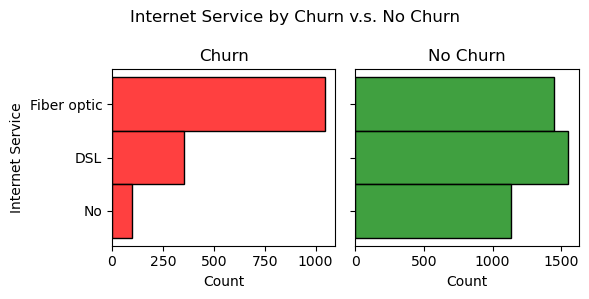

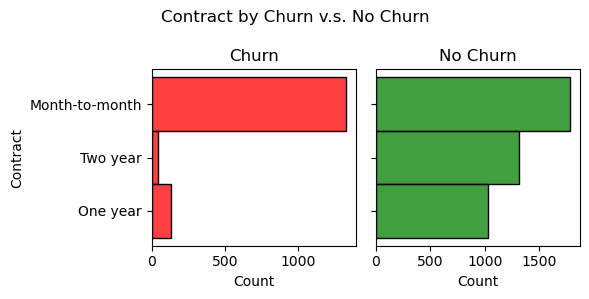

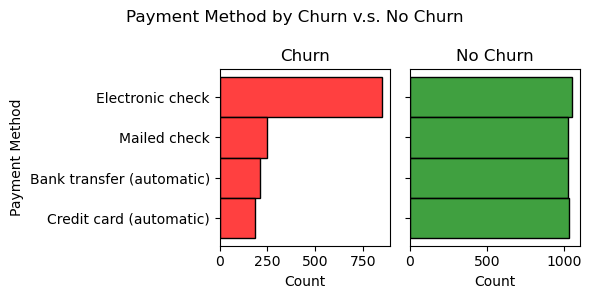

In [25]:
for c in features:
    fig,ax = plt.subplots(1,2,figsize=(6,3), sharey=True)
    sns.histplot(data=churn, y=c, ax=ax[0], color="red")
    sns.histplot(data=no_churn, y=c, ax=ax[1], color="green")
    ax[0].set_title("Churn")
    ax[1].set_title("No Churn")
    fig.suptitle(f"{c.title()} by Churn v.s. No Churn")
    fig.tight_layout()
    plt.show()

In [26]:
### return list of categorical features
def get_numeric_cols(data, drop_cols):
    categories = data.select_dtypes(exclude="object").columns 
    features =  [c for c in categories if c not in drop_cols]
    print("Numeric features: ",features)
    return features

In [27]:
num_drop_cols = ['CustomerID', 'City', 'Country', 'State', 'Count', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Reason',
                'Zip Code', 'Churn Value']

num_features = get_numeric_cols(df_transformed, num_drop_cols)

Numeric features:  ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Paperless Billing', 'Monthly Charges', 'Total Charges']


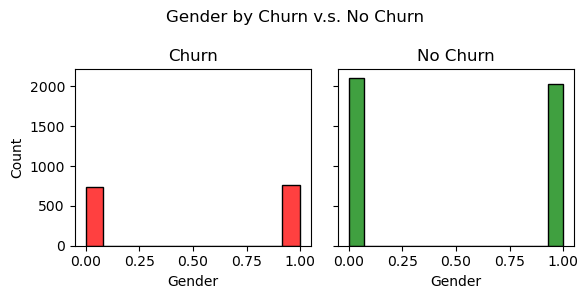

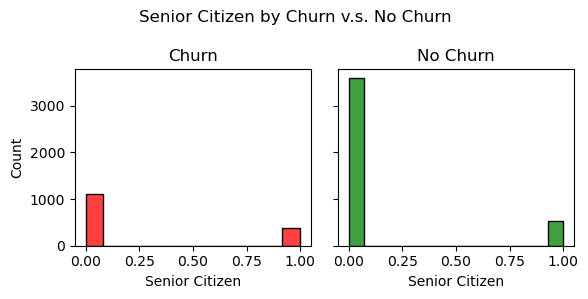

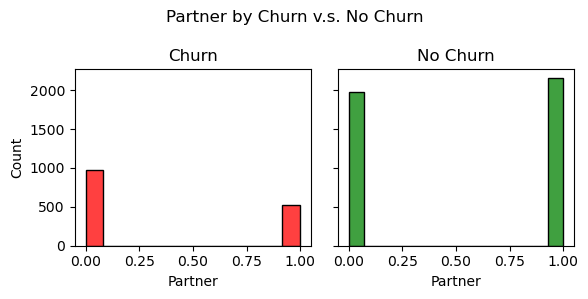

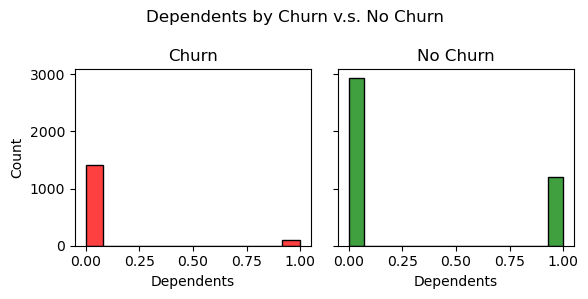

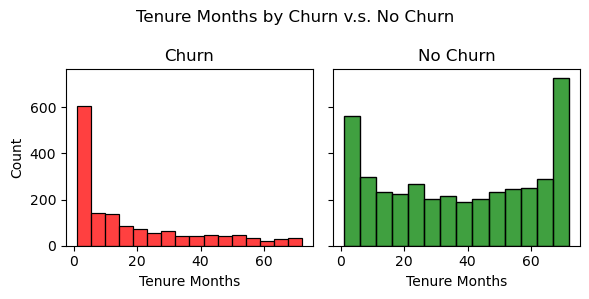

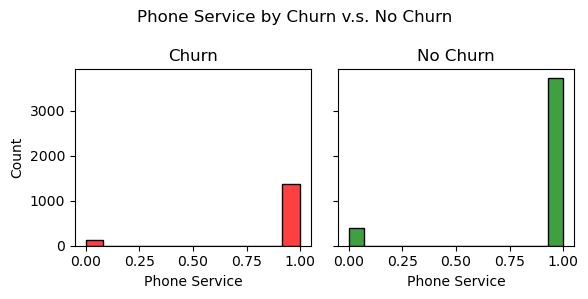

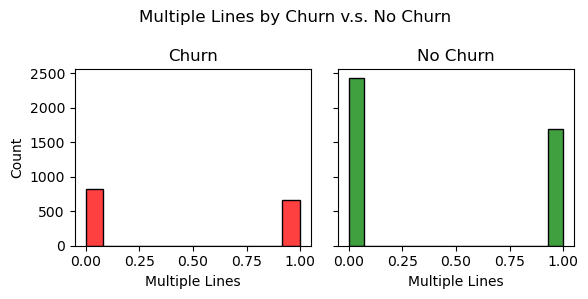

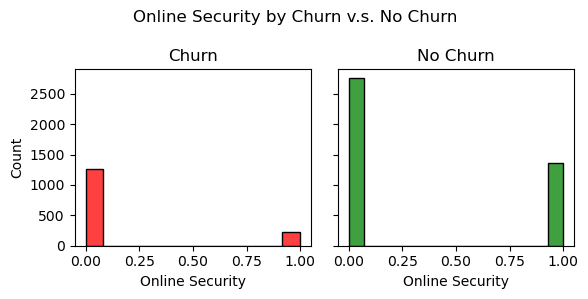

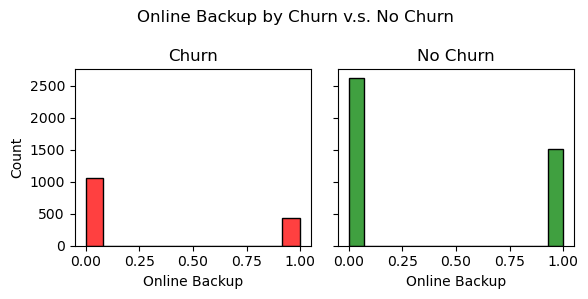

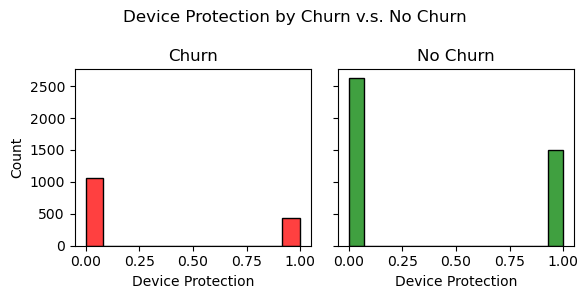

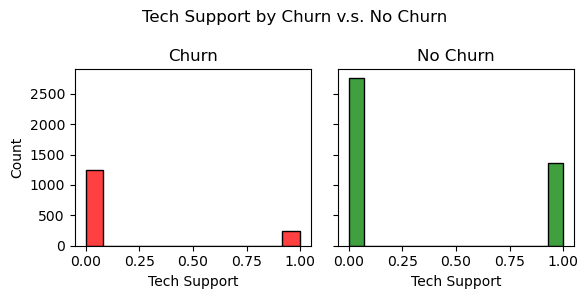

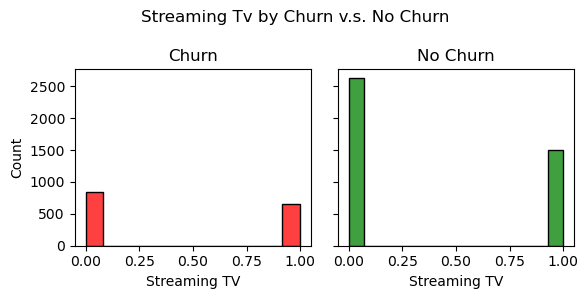

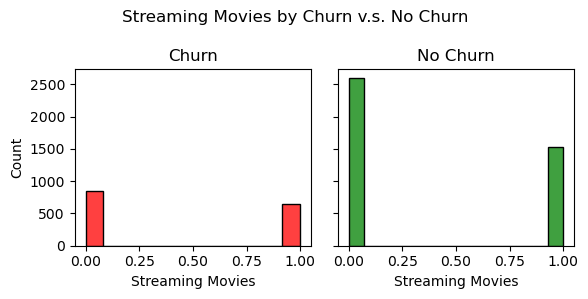

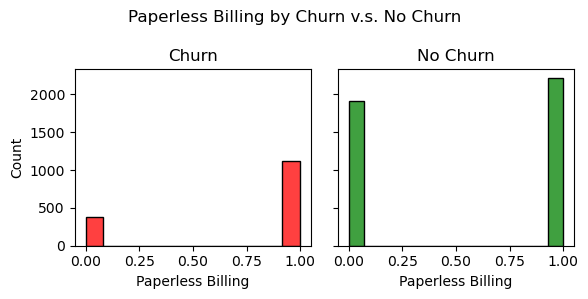

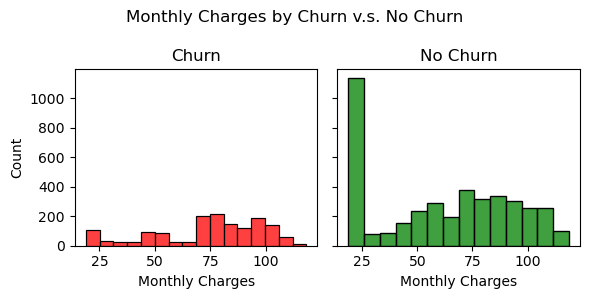

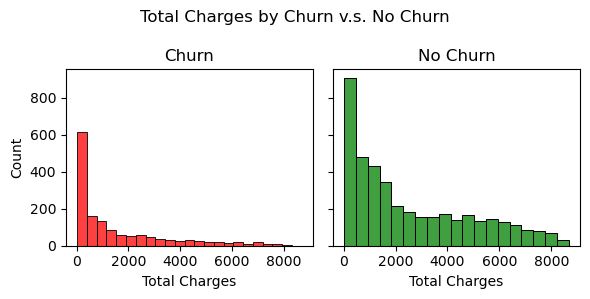

In [28]:
for c in num_features:
    fig,ax = plt.subplots(1,2,figsize=(6,3), sharey=True)
    sns.histplot(data=churn, x=c, ax=ax[0], color="red")
    sns.histplot(data=no_churn, x=c, ax=ax[1], color="green")
    ax[0].set_title("Churn")
    ax[1].set_title("No Churn")
    fig.suptitle(f"{c.title()} by Churn v.s. No Churn")
    fig.tight_layout()
    plt.show()

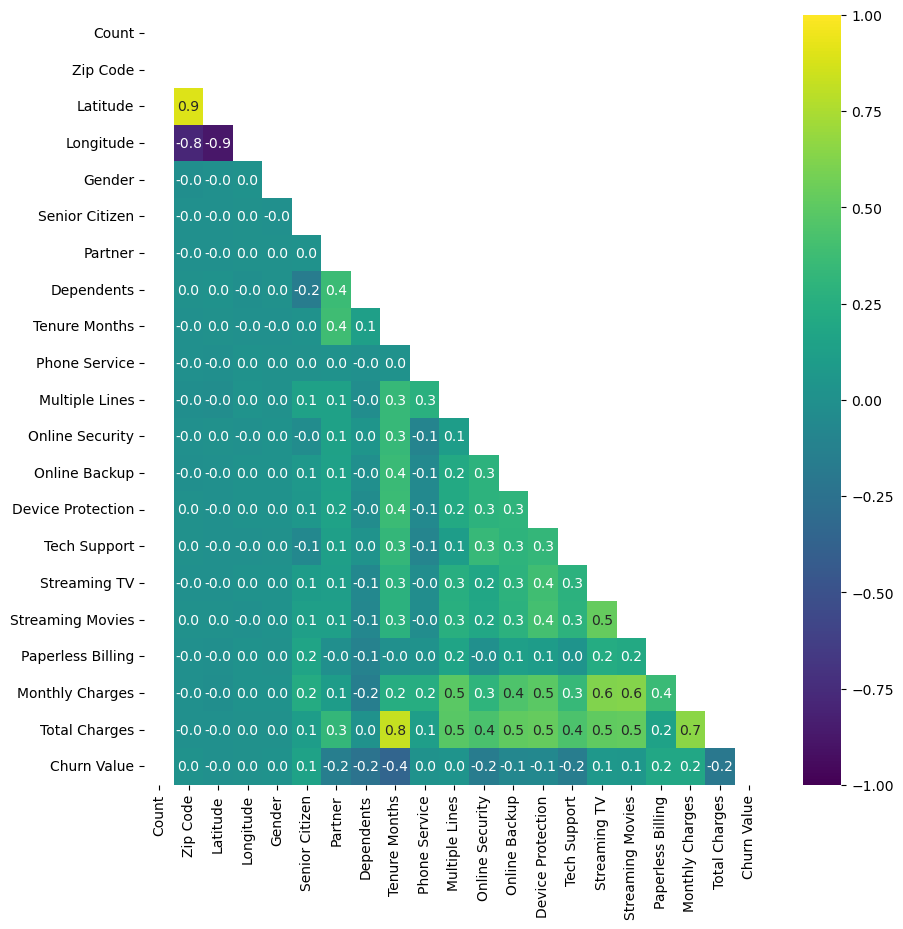

In [29]:
plt.figure(figsize=(10,10))
sns.heatmap(df_transformed.corr(numeric_only=True),
           vmin=-1, vmax=1, annot=True, cmap='viridis', fmt='.1f',
           mask=np.triu(df_transformed.corr(numeric_only=True))
           )
plt.show()

### Findings on Customers who did not churn (yet)
* `Churn Reason` is empty when Customer did not churn.
* Features that correlate with customers that do not churn:
    * `Senior Citizen`: Most customers who did not churn are not senior citizens, however in general this telco do not have a large senior citizen customer demographic.
    * `Dependents`: Customers who do not have dependents are more unlikely to churn .
    * `Tenure Months`: Customers with more than 65 months' tenure are more unlikely to churn.
    * `Phone Service`: Customers with phone service are more unlikely to churn.
    * `Online Security`, `Online Backup`, `Device Protection`, `Tech Support`: Customer who did not opt-in for these add-ons are more unlikely to churn. **Caveat**: these share similar pattern for customers who churned as well.
    * `Streaming TV`, `Streaming Movies`: Customers who do not stream TV or movies are less likely to churn.
    * `Monthly Charges`: High number of customers with monthly charges below 25 are less likely to churn.
    * `Total Charges`: High number of customers with total charges below 500 are less likely to churn. **Caveat**: similar pattern for customers who churned as well.
* `Internet Service`, `Contract`, `Payment Method`: No significant patterns for customers who did not churn.
* Looking at the heatmap, we have `Total Charges` correlated very strongly with `Monthly Charges` and `Tenure Months`. This brings the question of multi-collinearity since it's likely that `Total Charges` = `Monthly Charges` * `Tenure Months`

In [30]:
## Checking on collinearity of Total Charges, Monthly Charges and Tenure Months
charges = df_transformed[['Total Charges', 'Monthly Charges', 'Tenure Months']]
charges['product_charges'] = charges['Monthly Charges'] * charges['Tenure Months']
charges

/var/folders/k5/_r7c2p9n4l7c8mj8yt2hzxgr0000gn/T/ipykernel_65881/2402796434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charges['product_charges'] = charges['Monthly Charges'] * charges['Tenure Months']


,Total Charges,Monthly Charges,Tenure Months,product_charges
CustomerID,,,,
3910-MRQOY,1496.45,19.40,72,1396.80
8224-UAXBZ,2540.10,45.35,58,2630.30
5816-QVHRX,3541.40,100.30,37,3711.10
6569-KTMDU,19.10,19.10,1,19.10
0310-VQXAM,178.80,19.85,9,178.65
...,...,...,...,...
6615-NGGZJ,1415.55,100.55,14,1407.70
2097-YVPKN,1654.75,25.75,65,1673.75
9971-ZWPBF,3625.20,108.90,34,3702.60


**Remark**: The product of `Monthly Charges` and `Tenure Months` could be more or less than the `Total Charges`, I'm uncertain what could be causing the discrepancies but regardless, we might be able to drop `Total Charges` if there's collinearity concerns in modelling.

## Feature Engineering

In [31]:
def feature_eng(data):
    '''
    Accepts dataset, performs mapping and one-hot encoding
    Returns transformed dataset
    '''
    data = mapper(data, True)

    ## One-hot encoding on 'Internet Service', 'Contract', 'Payment Method'
    data = pd.get_dummies(data, columns=['Internet Service'], prefix="internet", dtype=int)
    data = pd.get_dummies(data, columns=['Contract'], prefix="contract", dtype=int)
    data = pd.get_dummies(data, columns=['Payment Method'], prefix="payment", dtype=int)
    
    return data

In [32]:
X_transformed = feature_eng(X_train)
X_transformed.head()

,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,...,internet_DSL,internet_Fiber optic,internet_No,contract_Month-to-month,contract_One year,contract_Two year,payment_Bank transfer (automatic),payment_Credit card (automatic),payment_Electronic check,payment_Mailed check
CustomerID,,,,,,,,,,,,,,,,,,,,,
3910-MRQOY,1,United States,California,Orick,95555,"41.336354, -124.044354",41.336354,-124.044354,1,0,...,0,0,1,0,0,1,1,0,0,0
8224-UAXBZ,1,United States,California,Sacramento,95827,"38.549185, -121.328386",38.549185,-121.328386,1,0,...,1,0,0,0,1,0,0,0,1,0
5816-QVHRX,1,United States,California,San Leandro,94579,"37.687264, -122.15728",37.687264,-122.157280,1,0,...,0,1,0,1,0,0,0,1,0,0
6569-KTMDU,1,United States,California,Sacramento,95826,"38.542532, -121.378826",38.542532,-121.378826,1,0,...,0,0,1,1,0,0,0,0,0,1
0310-VQXAM,1,United States,California,San Bernardino,92404,"34.183286, -117.221722",34.183286,-117.221722,0,0,...,0,0,1,1,0,0,0,0,0,1


In [33]:
## drop columns
drop_cols = ['Count', 'Country', 'State', 'City', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Reason', 'Total Charges']
X_transformed.drop(drop_cols, axis=1, inplace=True)
X_transformed.head()

,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Online Security,Online Backup,...,internet_DSL,internet_Fiber optic,internet_No,contract_Month-to-month,contract_One year,contract_Two year,payment_Bank transfer (automatic),payment_Credit card (automatic),payment_Electronic check,payment_Mailed check
CustomerID,,,,,,,,,,,,,,,,,,,,,
3910-MRQOY,95555,1,0,1,0,72,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0
8224-UAXBZ,95827,1,0,1,0,58,0,0,1,1,...,1,0,0,0,1,0,0,0,1,0
5816-QVHRX,94579,1,0,0,0,37,1,1,0,0,...,0,1,0,1,0,0,0,1,0,0
6569-KTMDU,95826,1,0,0,0,1,1,0,0,0,...,0,0,1,1,0,0,0,0,0,1
0310-VQXAM,92404,0,0,0,0,9,1,0,0,0,...,0,0,1,1,0,0,0,0,0,1


In [34]:
assert(all(X_transformed.index==y_train.index)), "Index mismatch in transformed training set"

## Modelling
* Metric: 'Recall'
* Decision Tree and Random Forest using Grid Search CV

In [35]:
# Display GridSearchCV results
def get_grid_results(grid):
    print("Best Estimator:")
    print(grid.best_estimator_)
    
    print("Best Hyperparameters:")
    print(grid.best_params_)
    
    print("Best Training Scores:")
    print(grid.best_score_)

### Decision Tree

In [36]:
dt = DecisionTreeClassifier()
dt_grid = {'max_depth': [2, 3, 4, 6, 8, 10],
           'min_samples_split': [5, 10, 15, 20, 50],
           'min_samples_leaf': [2, 5, 10, 20, 50],
           'criterion': ['gini', 'entropy'],
           'random_state': [1204]
          }

In [37]:
gcv = GridSearchCV(dt,
                   param_grid=dt_grid,
                   cv=10,
                   refit=True,
                   scoring='recall',
                   verbose=1,
                   n_jobs=-1)

In [38]:
start = time()
gcv.fit(X_transformed, y_train)
print(f"Time elapsed: {time() - start :.5f}")

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Time elapsed: 5.75935


In [39]:
get_grid_results(gcv)

Best Estimator:
DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, min_samples_split=5,
                       random_state=1204)
Best Hyperparameters:
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 5, 'random_state': 1204}
Best Training Scores:
0.6274720357941834


### Evaluation on training and test set

In [40]:
def eval_metrics(y_actual, y_pred):
    accuracy = metrics.accuracy_score(y_actual, y_pred)
    precision = metrics.precision_score(y_actual, y_pred, zero_division=0.0)
    recall = metrics.recall_score(y_actual, y_pred, zero_division=0.0)
    f1 = metrics.f1_score(y_actual, y_pred)
    
    # print(f"Accuracy:{accuracy}")
    # print(f"Precision:{precision}")
    # print(f"Recall:{recall}")
    # print(f"F1:{f1}")
    return accuracy, precision, recall, f1

In [41]:
def eval_set(y_actual, pred):
    dt_scores = []
    ### create thresholds
    thresholds = np.arange(0.1, 1.1, 0.1)
    
    for t in thresholds:
        y_pred = np.where(pred[:,1] >= t, 1, 0)
        dt_scores.append(eval_metrics(y_actual, y_pred))
        
    df_scores = pd.DataFrame(dt_scores, columns=['accuracy', 'precision', 'recall', 'f1'])
    df_scores.insert(0, column='threshold', value=thresholds)
    df_scores.set_index('threshold')
    return df_scores

In [42]:
train_pred = gcv.predict_proba(X_transformed)

In [43]:
### Evaluation on training set
df_scores = eval_set(y_train, train_pred)
df_scores

,threshold,accuracy,precision,recall,f1
0,0.1,0.576855,0.381054,0.952508,0.544343
1,0.2,0.653000,0.426093,0.886957,0.575646
2,0.3,0.762336,0.545349,0.627425,0.583515
3,0.4,0.762336,0.545349,0.627425,0.583515
4,0.5,0.762336,0.545349,0.627425,0.583515
5,0.6,0.734647,0.000000,0.000000,0.000000
6,0.7,0.734647,0.000000,0.000000,0.000000
7,0.8,0.734647,0.000000,0.000000,0.000000
8,0.9,0.734647,0.000000,0.000000,0.000000
9,1.0,0.734647,0.000000,0.000000,0.000000


In [44]:
### Try best model on test set
test_transformed = feature_eng(X_test)
test_transformed.drop(drop_cols, axis=1, inplace=True)
assert(all(test_transformed.index==y_test.index)), "Index mismatch in transformed test set"

In [45]:
test_pred = gcv.predict_proba(test_transformed)

### Evaluation on test set
df_scores = eval_set(y_test, test_pred)
df_scores

,threshold,accuracy,precision,recall,f1
0,0.1,0.581263,0.382096,0.935829,0.542636
1,0.2,0.660043,0.431193,0.879679,0.578716
2,0.3,0.762952,0.549020,0.598930,0.572890
3,0.4,0.762952,0.549020,0.598930,0.572890
4,0.5,0.762952,0.549020,0.598930,0.572890
5,0.6,0.734564,0.000000,0.000000,0.000000
6,0.7,0.734564,0.000000,0.000000,0.000000
7,0.8,0.734564,0.000000,0.000000,0.000000
8,0.9,0.734564,0.000000,0.000000,0.000000
9,1.0,0.734564,0.000000,0.000000,0.000000


### Random Forest Classifier

In [46]:
rf = RandomForestClassifier()
rf_grid = {'n_estimators': [100, 250, 500],
           'max_depth': [2, 3, 4, 6, 8],
           'min_samples_split': [5, 10, 15, 20, 50],
           'min_samples_leaf': [2, 5, 10, 20, 50],
           'random_state': [1204]
          }

In [47]:
gcv_rf = GridSearchCV(rf,
                   param_grid=rf_grid,
                   cv=10,
                   refit=True,
                   scoring='recall',
                   verbose=1,
                   n_jobs=-1)

In [48]:
start = time()
gcv_rf.fit(X_transformed, y_train)
print(f"Time elapsed: {time() - start :.5f}")

Fitting 10 folds for each of 375 candidates, totalling 3750 fits
Time elapsed: 242.37027


In [49]:
get_grid_results(gcv_rf)

Best Estimator:
RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=500, random_state=1204)
Best Hyperparameters:
{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500, 'random_state': 1204}
Best Training Scores:
0.5050469798657719


### Evaluation on training and test set

In [50]:
train_pred = gcv_rf.predict_proba(X_transformed)

### Evaluation on training set
df_scores = eval_set(y_train, train_pred)
df_scores

,threshold,accuracy,precision,recall,f1
0,0.1,0.609691,0.404348,0.995318,0.575072
1,0.2,0.743876,0.509213,0.961204,0.665740
2,0.3,0.806177,0.592559,0.862876,0.702614
3,0.4,0.833866,0.668678,0.741137,0.703046
4,0.5,0.829961,0.736564,0.559197,0.635741
5,0.6,0.812567,0.829085,0.369900,0.511563
6,0.7,0.787717,0.914127,0.220736,0.355603
7,0.8,0.742102,0.977273,0.028763,0.055880
8,0.9,0.734647,0.000000,0.000000,0.000000
9,1.0,0.734647,0.000000,0.000000,0.000000


In [51]:
test_pred = gcv_rf.predict_proba(test_transformed)

### Evaluation on test set
df_scores = eval_set(y_test, test_pred)
df_scores

,threshold,accuracy,precision,recall,f1
0,0.1,0.586941,0.389831,0.983957,0.558422
1,0.2,0.727466,0.492775,0.911765,0.639775
2,0.3,0.795600,0.582061,0.815508,0.679287
3,0.4,0.819730,0.651515,0.689840,0.670130
4,0.5,0.810504,0.695971,0.508021,0.587326
5,0.6,0.783534,0.719745,0.302139,0.425612
6,0.7,0.757275,0.766667,0.122995,0.211982
7,0.8,0.739532,0.888889,0.021390,0.041775
8,0.9,0.734564,0.000000,0.000000,0.000000
9,1.0,0.734564,0.000000,0.000000,0.000000
